# Timeseries data

In this example we calculate the data of a wind farm with 67 turbines in a time series containing 8000 uniform inflow states.

The required imports are:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV
import foxes.constants as FC
from foxes.utils.runners import DaskRunner

First, we create the `states`. The `data_source` can be any csv-type file (or `pandas` readable equivalent), or a `pandas.DataFrame` object. If it is a file path, then it will first be searched in the file system, and if not found, in the static data. If it is also not found there, an error showing the available static data file names is displayed.

In this example the static data file `timeseries_8000.csv.gz` will be used, with content
```
Time,ws,wd,ti
2017-01-01 00:00:00,15.62,244.06,0.0504
2017-01-01 00:30:00,15.99,243.03,0.0514
2017-01-01 01:00:00,16.31,243.01,0.0522
2017-01-01 01:30:00,16.33,241.26,0.0523
...
```
Notice the column names, and how they appear in the `Timeseries` constructor:

In [2]:
states = foxes.input.states.Timeseries(
    data_source="timeseries_8000.csv.gz",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "ws", FV.WD: "wd", FV.TI: "ti"},
    fixed_vars={FV.RHO: 1.225},
)

We can visualize the wind distribution via the `StatesRosePlotOutput`. Here we display the ambient wind speed in a wind rose with 16 wind direction sectors and 5 wind speed bins: 

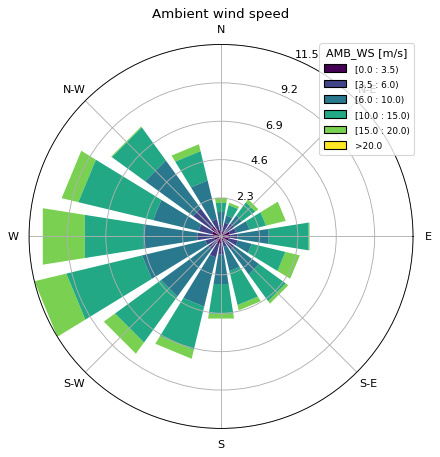

In [3]:
o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

For the time series with uniform data, any choice of the `point` argument will produce the same figure.

Next, we create the example wind farm with 67 turbines from static data. The file `test_farm_67.csv` has the following structure:
```
index,label,x,y
0,T0,101872.70,1004753.57
1,T1,103659.97,1002993.29
2,T2,100780.09,1000779.97
3,T3,100290.42,1004330.88
...
```
For more options, check the API section `foxes.input.farm_layout`. 

We consider two turbine models in this example: the wind turbine type `NREL5MW` and the turbine model `kTI_02`, both from the default model book. The latter model adds the variable `k` for each state and turbine, calculated as `k = kTI * TI`, with constant `kTI = 0.2`. The parameter `k` will later be used by the wake model.

In [4]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_from_file(
    farm, "test_farm_67.csv", turbine_models=["kTI_02", "NREL5MW"], verbosity=0
)

Next, we create the `algorithm`, with further model selections. In particular, two wake models are invoked, the model `Bastankhah_quadratic` for wind speed deficits and the model `CrespoHernandez_max` for turbulence intensity:

In [5]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="centre",
    wake_models=["Bastankhah2014_quadratic", "CrespoHernandez_max"],
    chunks={FC.STATE: 1000},
    verbosity=0,
)

Also notice the `chunks` parameter, specifying that always 1000 states should be considered in vectorized form during calculations. The progress is automatically visualized when invoking the `DaskRunner`:

In [6]:
with DaskRunner() as runner:
    farm_results = runner.run(algo.calc_farm)

fr = farm_results.to_dataframe()
print("\n", fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.AMB_P, FV.P]])

[                                        ] | 0% Completed | 330.31 us

[########################################] | 100% Completed | 102.64 ms

[                                        ] | 0% Completed | 386.34 us

[##                                      ] | 6% Completed | 115.25 ms

[##                                      ] | 6% Completed | 227.80 ms

[##                                      ] | 6% Completed | 343.59 ms

[##                                      ] | 6% Completed | 454.33 ms

[##                                      ] | 6% Completed | 558.99 ms

[##                                      ] | 6% Completed | 663.97 ms

[##                                      ] | 6% Completed | 770.53 ms

[##                                      ] | 6% Completed | 881.07 ms

[##                                      ] | 6% Completed | 989.85 ms

[##                                      ] | 6% Completed | 1.10 s

[##                                      ] | 6% Completed | 1.20 s

[##                                      ] | 6% Completed | 1.31 s

[##                                      ] | 6% Completed | 1.41 s

[##                                      ] | 6% Completed | 1.52 s

[##                                      ] | 6% Completed | 1.63 s

[##                                      ] | 6% Completed | 1.73 s

[##                                      ] | 6% Completed | 1.84 s

[##                                      ] | 6% Completed | 1.94 s

[##                                      ] | 6% Completed | 2.05 s

[##                                      ] | 6% Completed | 2.16 s

[##                                      ] | 6% Completed | 2.27 s

[##                                      ] | 6% Completed | 2.37 s

[##                                      ] | 6% Completed | 2.48 s

[##                                      ] | 6% Completed | 2.59 s

[##                                      ] | 6% Completed | 2.70 s

[##                                      ] | 6% Completed | 2.80 s

[##                                      ] | 6% Completed | 2.91 s

[##                                      ] | 6% Completed | 3.01 s

[##                                      ] | 6% Completed | 3.12 s

[##                                      ] | 6% Completed | 3.22 s

[##                                      ] | 6% Completed | 3.33 s

[##                                      ] | 6% Completed | 3.44 s

[##                                      ] | 6% Completed | 3.55 s

[##                                      ] | 6% Completed | 3.65 s

[##                                      ] | 6% Completed | 3.76 s

[##                                      ] | 6% Completed | 3.87 s

[##                                      ] | 6% Completed | 3.98 s

[##                                      ] | 6% Completed | 4.09 s

[##                                      ] | 6% Completed | 4.19 s

[##                                      ] | 6% Completed | 4.30 s

[##                                      ] | 6% Completed | 4.40 s

[##                                      ] | 6% Completed | 4.51 s

[##                                      ] | 6% Completed | 4.61 s

[##                                      ] | 6% Completed | 4.72 s

[##                                      ] | 6% Completed | 4.83 s

[##                                      ] | 6% Completed | 4.93 s

[##                                      ] | 6% Completed | 5.04 s

[##                                      ] | 6% Completed | 5.14 s

[##                                      ] | 6% Completed | 5.25 s

[##                                      ] | 6% Completed | 5.36 s

[##                                      ] | 6% Completed | 5.46 s

[##                                      ] | 6% Completed | 5.57 s

[##                                      ] | 6% Completed | 5.68 s

[##                                      ] | 6% Completed | 5.79 s

[##                                      ] | 6% Completed | 5.89 s

[##                                      ] | 6% Completed | 6.00 s

[##                                      ] | 6% Completed | 6.10 s

[##                                      ] | 6% Completed | 6.21 s

[##                                      ] | 6% Completed | 6.31 s

[##                                      ] | 6% Completed | 6.42 s

[##                                      ] | 6% Completed | 6.52 s

[##                                      ] | 6% Completed | 6.63 s

[##                                      ] | 6% Completed | 6.74 s

[##                                      ] | 6% Completed | 6.84 s

[##                                      ] | 6% Completed | 6.95 s

[##                                      ] | 6% Completed | 7.06 s

[##                                      ] | 6% Completed | 7.16 s

[##                                      ] | 6% Completed | 7.27 s

[##                                      ] | 6% Completed | 7.38 s

[##                                      ] | 6% Completed | 7.48 s

[##                                      ] | 6% Completed | 7.59 s

[##                                      ] | 6% Completed | 7.69 s

[##                                      ] | 6% Completed | 7.80 s

[##                                      ] | 6% Completed | 7.91 s

[##                                      ] | 6% Completed | 8.01 s

[##                                      ] | 6% Completed | 8.12 s

[##                                      ] | 6% Completed | 8.22 s

[##                                      ] | 6% Completed | 8.32 s

[##                                      ] | 6% Completed | 8.43 s

[##                                      ] | 6% Completed | 8.54 s

[##                                      ] | 6% Completed | 8.65 s

[##                                      ] | 6% Completed | 8.75 s

[##                                      ] | 6% Completed | 8.86 s

[##                                      ] | 6% Completed | 8.96 s

[##                                      ] | 6% Completed | 9.07 s

[##                                      ] | 6% Completed | 9.17 s

[##                                      ] | 6% Completed | 9.29 s

[##                                      ] | 6% Completed | 9.39 s

[##                                      ] | 6% Completed | 9.50 s

[##                                      ] | 6% Completed | 9.61 s

[##                                      ] | 6% Completed | 9.72 s

[##                                      ] | 6% Completed | 9.82 s

[##                                      ] | 6% Completed | 9.93 s

[##                                      ] | 6% Completed | 10.04 s

[##                                      ] | 6% Completed | 10.15 s

[##                                      ] | 6% Completed | 10.25 s

[##                                      ] | 6% Completed | 10.36 s

[##                                      ] | 6% Completed | 10.47 s

[##                                      ] | 6% Completed | 10.58 s

[##                                      ] | 6% Completed | 10.69 s

[##                                      ] | 6% Completed | 10.79 s

[##                                      ] | 6% Completed | 10.90 s

[##                                      ] | 6% Completed | 11.00 s

[##                                      ] | 6% Completed | 11.11 s

[##                                      ] | 6% Completed | 11.22 s

[##                                      ] | 6% Completed | 11.33 s

[##                                      ] | 6% Completed | 11.43 s

[##                                      ] | 6% Completed | 11.54 s

[##                                      ] | 6% Completed | 11.65 s

[##                                      ] | 6% Completed | 11.75 s

[##                                      ] | 6% Completed | 11.86 s

[##                                      ] | 6% Completed | 11.96 s

[##                                      ] | 6% Completed | 12.07 s

[##                                      ] | 6% Completed | 12.17 s

[##                                      ] | 6% Completed | 12.28 s

[##                                      ] | 6% Completed | 12.38 s

[##                                      ] | 6% Completed | 12.49 s

[##                                      ] | 6% Completed | 12.60 s

[##                                      ] | 6% Completed | 12.70 s

[##                                      ] | 6% Completed | 12.81 s

[##                                      ] | 6% Completed | 12.91 s

[##                                      ] | 6% Completed | 13.02 s

[##                                      ] | 6% Completed | 13.13 s

[##                                      ] | 6% Completed | 13.23 s

[##                                      ] | 6% Completed | 13.34 s

[##                                      ] | 6% Completed | 13.44 s

[##                                      ] | 6% Completed | 13.55 s

[##                                      ] | 6% Completed | 13.65 s

[##                                      ] | 6% Completed | 13.76 s

[##                                      ] | 6% Completed | 13.87 s

[##                                      ] | 6% Completed | 13.98 s

[##                                      ] | 6% Completed | 14.09 s

[##                                      ] | 6% Completed | 14.19 s

[##                                      ] | 6% Completed | 14.30 s

[##                                      ] | 6% Completed | 14.41 s

[##                                      ] | 6% Completed | 14.51 s

[##                                      ] | 6% Completed | 14.62 s

[##                                      ] | 6% Completed | 14.72 s

[##                                      ] | 6% Completed | 14.82 s

[##                                      ] | 6% Completed | 14.93 s

[##                                      ] | 6% Completed | 15.04 s

[##                                      ] | 6% Completed | 15.14 s

[##                                      ] | 6% Completed | 15.25 s

[##                                      ] | 6% Completed | 15.36 s

[##                                      ] | 6% Completed | 15.46 s

[##                                      ] | 6% Completed | 15.57 s

[##                                      ] | 6% Completed | 15.67 s

[##                                      ] | 6% Completed | 15.78 s

[##                                      ] | 6% Completed | 15.89 s

[##                                      ] | 6% Completed | 16.01 s

[##                                      ] | 6% Completed | 16.12 s

[##                                      ] | 6% Completed | 16.22 s

[##                                      ] | 6% Completed | 16.33 s

[##                                      ] | 6% Completed | 16.44 s

[##                                      ] | 6% Completed | 16.54 s

[##                                      ] | 6% Completed | 16.65 s

[##                                      ] | 6% Completed | 16.76 s

[##                                      ] | 6% Completed | 16.87 s

[##                                      ] | 6% Completed | 16.98 s

[##                                      ] | 6% Completed | 17.09 s

[##                                      ] | 6% Completed | 17.20 s

[##                                      ] | 6% Completed | 17.31 s

[##                                      ] | 6% Completed | 17.41 s

[##                                      ] | 6% Completed | 17.52 s

[##                                      ] | 6% Completed | 17.63 s

[##                                      ] | 6% Completed | 17.74 s

[##                                      ] | 6% Completed | 17.84 s

[##                                      ] | 6% Completed | 17.95 s

[##                                      ] | 6% Completed | 18.07 s

[##                                      ] | 6% Completed | 18.17 s

[##                                      ] | 6% Completed | 18.28 s

[##                                      ] | 6% Completed | 18.40 s

[##                                      ] | 6% Completed | 18.50 s

[##                                      ] | 6% Completed | 18.61 s

[##                                      ] | 6% Completed | 18.72 s

[##                                      ] | 6% Completed | 18.83 s

[##                                      ] | 6% Completed | 18.94 s

[##                                      ] | 6% Completed | 19.05 s

[##                                      ] | 6% Completed | 19.15 s

[##                                      ] | 6% Completed | 19.26 s

[##                                      ] | 6% Completed | 19.37 s

[##                                      ] | 6% Completed | 19.48 s

[##                                      ] | 6% Completed | 19.59 s

[##                                      ] | 6% Completed | 19.70 s

[##                                      ] | 6% Completed | 19.81 s

[##                                      ] | 6% Completed | 19.92 s

[##                                      ] | 6% Completed | 20.03 s

[##                                      ] | 6% Completed | 20.14 s

[##                                      ] | 6% Completed | 20.24 s

[##                                      ] | 6% Completed | 20.35 s

[##                                      ] | 6% Completed | 20.46 s

[##                                      ] | 6% Completed | 20.57 s

[##                                      ] | 6% Completed | 20.67 s

[##                                      ] | 6% Completed | 20.78 s

[##                                      ] | 6% Completed | 20.88 s

[##                                      ] | 6% Completed | 20.99 s

[##                                      ] | 6% Completed | 21.10 s

[##                                      ] | 6% Completed | 21.21 s

[##                                      ] | 6% Completed | 21.32 s

[##                                      ] | 6% Completed | 21.43 s

[##                                      ] | 6% Completed | 21.53 s

[##                                      ] | 6% Completed | 21.65 s

[##                                      ] | 6% Completed | 21.76 s

[##                                      ] | 6% Completed | 21.87 s

[##                                      ] | 6% Completed | 21.99 s

[##                                      ] | 6% Completed | 22.10 s

[##                                      ] | 6% Completed | 22.21 s

[##                                      ] | 6% Completed | 22.32 s

[##                                      ] | 6% Completed | 22.43 s

[##                                      ] | 6% Completed | 22.54 s

[##                                      ] | 6% Completed | 22.64 s

[##                                      ] | 6% Completed | 22.76 s

[##                                      ] | 6% Completed | 22.87 s

[##                                      ] | 6% Completed | 22.97 s

[##                                      ] | 6% Completed | 23.08 s

[##                                      ] | 6% Completed | 23.20 s

[##                                      ] | 6% Completed | 23.32 s

[##                                      ] | 6% Completed | 23.42 s

[##                                      ] | 6% Completed | 23.53 s

[##                                      ] | 6% Completed | 23.64 s

[##                                      ] | 6% Completed | 23.75 s

[##                                      ] | 6% Completed | 23.86 s

[##                                      ] | 6% Completed | 23.96 s

[##                                      ] | 6% Completed | 24.07 s

[##                                      ] | 6% Completed | 24.17 s

[##                                      ] | 6% Completed | 24.29 s

[##                                      ] | 6% Completed | 24.39 s

[##                                      ] | 6% Completed | 24.50 s

[##                                      ] | 6% Completed | 24.61 s

[##                                      ] | 6% Completed | 24.72 s

[##                                      ] | 6% Completed | 24.83 s

[##                                      ] | 6% Completed | 24.93 s

[##                                      ] | 6% Completed | 25.04 s

[##                                      ] | 6% Completed | 25.15 s

[##                                      ] | 6% Completed | 25.26 s

[##                                      ] | 6% Completed | 25.36 s

[##                                      ] | 6% Completed | 25.47 s

[##                                      ] | 6% Completed | 25.57 s

[##                                      ] | 6% Completed | 25.68 s

[##                                      ] | 6% Completed | 25.79 s

[##                                      ] | 6% Completed | 25.90 s

[##                                      ] | 6% Completed | 26.00 s

[##                                      ] | 6% Completed | 26.11 s

[##                                      ] | 6% Completed | 26.21 s

[##                                      ] | 6% Completed | 26.32 s

[##                                      ] | 6% Completed | 26.42 s

[##                                      ] | 6% Completed | 26.54 s

[##                                      ] | 6% Completed | 26.64 s

[##                                      ] | 6% Completed | 26.75 s

[##                                      ] | 6% Completed | 26.86 s

[##                                      ] | 6% Completed | 26.97 s

[##                                      ] | 6% Completed | 27.08 s

[##                                      ] | 6% Completed | 27.19 s

[##                                      ] | 6% Completed | 27.30 s

[##                                      ] | 6% Completed | 27.41 s

[##                                      ] | 6% Completed | 27.52 s

[##                                      ] | 6% Completed | 27.62 s

[##                                      ] | 6% Completed | 27.74 s

[##                                      ] | 6% Completed | 27.84 s

[##                                      ] | 6% Completed | 27.95 s

[##                                      ] | 6% Completed | 28.05 s

[##                                      ] | 6% Completed | 28.16 s

[##                                      ] | 6% Completed | 28.27 s

[##                                      ] | 6% Completed | 28.38 s

[##                                      ] | 6% Completed | 28.49 s

[##                                      ] | 6% Completed | 28.59 s

[##                                      ] | 6% Completed | 28.70 s

[##                                      ] | 6% Completed | 28.80 s

[##                                      ] | 6% Completed | 28.91 s

[##                                      ] | 6% Completed | 29.01 s

[##                                      ] | 6% Completed | 29.12 s

[##                                      ] | 6% Completed | 29.24 s

[##                                      ] | 6% Completed | 29.34 s

[##                                      ] | 6% Completed | 29.45 s

[##                                      ] | 6% Completed | 29.56 s

[##                                      ] | 6% Completed | 29.67 s

[##                                      ] | 6% Completed | 29.78 s

[##                                      ] | 6% Completed | 29.89 s

[##                                      ] | 6% Completed | 29.99 s

[##                                      ] | 6% Completed | 30.10 s

[##                                      ] | 6% Completed | 30.21 s

[##                                      ] | 6% Completed | 30.31 s

[##                                      ] | 6% Completed | 30.42 s

[##                                      ] | 6% Completed | 30.53 s

[##                                      ] | 6% Completed | 30.64 s

[##                                      ] | 6% Completed | 30.74 s

[##                                      ] | 6% Completed | 30.85 s

[##                                      ] | 6% Completed | 30.96 s

[##                                      ] | 6% Completed | 31.06 s

[##                                      ] | 6% Completed | 31.17 s

[##                                      ] | 6% Completed | 31.28 s

[##                                      ] | 6% Completed | 31.38 s

[##                                      ] | 6% Completed | 31.49 s

[##                                      ] | 6% Completed | 31.60 s

[##                                      ] | 6% Completed | 31.71 s

[##                                      ] | 6% Completed | 31.81 s

[##                                      ] | 6% Completed | 31.92 s

[##                                      ] | 6% Completed | 32.03 s

[##                                      ] | 6% Completed | 32.16 s

[##                                      ] | 6% Completed | 32.27 s

[##                                      ] | 6% Completed | 32.39 s

[##                                      ] | 6% Completed | 32.50 s

[##                                      ] | 6% Completed | 32.60 s

[##                                      ] | 6% Completed | 32.71 s

[##                                      ] | 6% Completed | 32.82 s

[##                                      ] | 6% Completed | 32.94 s

[##                                      ] | 6% Completed | 33.05 s

[##                                      ] | 6% Completed | 33.15 s

[##                                      ] | 6% Completed | 33.27 s

[##                                      ] | 6% Completed | 33.38 s

[##                                      ] | 6% Completed | 33.49 s

[##                                      ] | 6% Completed | 33.61 s

[##                                      ] | 6% Completed | 33.71 s

[##                                      ] | 6% Completed | 33.82 s

[##                                      ] | 6% Completed | 33.93 s

[##                                      ] | 6% Completed | 34.04 s

[##                                      ] | 6% Completed | 34.15 s

[##                                      ] | 6% Completed | 34.26 s

[##                                      ] | 6% Completed | 34.37 s

[##                                      ] | 6% Completed | 34.48 s

[##                                      ] | 6% Completed | 34.58 s

[##                                      ] | 6% Completed | 34.69 s

[##                                      ] | 6% Completed | 34.80 s

[##                                      ] | 6% Completed | 34.91 s

[##                                      ] | 6% Completed | 35.01 s

[##                                      ] | 6% Completed | 35.13 s

[##                                      ] | 6% Completed | 35.24 s

[##                                      ] | 6% Completed | 35.34 s

[##                                      ] | 6% Completed | 35.46 s

[##                                      ] | 6% Completed | 35.57 s

[##                                      ] | 6% Completed | 35.67 s

[##                                      ] | 6% Completed | 35.78 s

[##                                      ] | 6% Completed | 35.89 s

[##                                      ] | 6% Completed | 36.00 s

[##                                      ] | 6% Completed | 36.11 s

[##                                      ] | 6% Completed | 36.21 s

[##                                      ] | 6% Completed | 36.32 s

[##                                      ] | 6% Completed | 36.42 s

[##                                      ] | 6% Completed | 36.53 s

[##                                      ] | 6% Completed | 36.64 s

[##                                      ] | 6% Completed | 36.75 s

[##                                      ] | 6% Completed | 36.87 s

[##                                      ] | 6% Completed | 36.97 s

[##                                      ] | 6% Completed | 37.07 s

[##                                      ] | 6% Completed | 37.19 s

[##                                      ] | 6% Completed | 37.29 s

[##                                      ] | 6% Completed | 37.40 s

[##                                      ] | 6% Completed | 37.50 s

[##                                      ] | 6% Completed | 37.61 s

[##                                      ] | 6% Completed | 37.71 s

[##                                      ] | 6% Completed | 37.82 s

[##                                      ] | 6% Completed | 37.93 s

[##                                      ] | 6% Completed | 38.04 s

[##                                      ] | 6% Completed | 38.15 s

[##                                      ] | 6% Completed | 38.26 s

[##                                      ] | 6% Completed | 38.37 s

[##                                      ] | 6% Completed | 38.47 s

[##                                      ] | 6% Completed | 38.58 s

[##                                      ] | 6% Completed | 38.69 s

[##                                      ] | 6% Completed | 38.79 s

[##                                      ] | 6% Completed | 38.90 s

[##                                      ] | 6% Completed | 39.01 s

[##                                      ] | 6% Completed | 39.11 s

[##                                      ] | 6% Completed | 39.22 s

[##                                      ] | 7% Completed | 39.33 s

[#####                                   ] | 12% Completed | 39.44 s

[#######                                 ] | 18% Completed | 39.55 s

[#######                                 ] | 18% Completed | 39.66 s

[#######                                 ] | 18% Completed | 39.76 s

[#######                                 ] | 18% Completed | 39.87 s

[#######                                 ] | 18% Completed | 39.98 s

[#######                                 ] | 18% Completed | 40.09 s

[#######                                 ] | 18% Completed | 40.20 s

[########                                ] | 22% Completed | 40.31 s

[###########                             ] | 29% Completed | 40.42 s

[###########                             ] | 29% Completed | 40.53 s

[############                            ] | 30% Completed | 40.64 s

[##############                          ] | 36% Completed | 40.75 s

[#################                       ] | 44% Completed | 40.86 s

[#######################                 ] | 58% Completed | 40.97 s

[##########################              ] | 65% Completed | 41.08 s

[###################################     ] | 88% Completed | 41.18 s

[########################################] | 100% Completed | 41.28 s


                                  WD  AMB_REWS       REWS    AMB_P            P
state               turbine                                                   
2017-01-01 00:00:00 0        244.06     15.62  15.610500  5000.00  5000.000000
                    1        244.06     15.62  14.012903  5000.00  5000.000000
                    2        244.06     15.62  15.021033  5000.00  5000.000000
                    3        244.06     15.62  15.560020  5000.00  5000.000000
                    4        244.06     15.62  14.564008  5000.00  5000.000000
...                             ...       ...        ...      ...          ...
2017-06-16 15:30:00 62       299.19     11.70   8.145984  4868.75  1880.222715
                    63       299.19     11.70  11.490711  4868.75  4777.186188
                    64       299.19     11.70  11.700000  4868.75  4868.750000
                    65       299.19     11.70  11.642754  4868.75  4843.705093
                    66       299.19     11.70   8.

Let's evaluate the results:

In [7]:
# add capacity and efficiency to farm_results:
o = foxes.output.FarmResultsEval(farm_results)
o.add_capacity(algo)
o.add_capacity(algo, ambient=True)
o.add_efficiency()

# print results by turbine:
turbine_results = o.reduce_states(
    {
        FV.AMB_P: "mean",
        FV.P: "mean",
        FV.AMB_CAP: "mean",
        FV.CAP: "mean",
        FV.EFF: "mean",
    }
)
turbine_results[FV.AMB_YLD] = o.calc_turbine_yield(algo=algo, annual=True, ambient=True)
turbine_results[FV.YLD] = o.calc_turbine_yield(algo=algo, annual=True)
print("\nResults by turbine:\n")
print(turbine_results)

# print power results:
P0 = o.calc_mean_farm_power(ambient=True)
P = o.calc_mean_farm_power()
print(f"\nFarm power        : {P/1000:.1f} MW")
print(f"Farm ambient power: {P0/1000:.1f} MW")
print(f"Farm efficiency   : {o.calc_farm_efficiency():.2f}")
print(f"Annual farm yield : {turbine_results[FV.YLD].sum():.2f} GWh")

Capacity added to farm results
Ambient capacity added to farm results
Efficiency added to farm results

Results by turbine:

               AMB_P            P   AMB_CAP       CAP       EFF    AMB_YLD  \
turbine                                                                      
0        3067.723397  2638.907209  0.613545  0.527781  0.774911  26.873257   
1        3067.723397  2299.506817  0.613545  0.459901  0.631419  26.873257   
2        3067.723397  2564.420645  0.613545  0.512884  0.730530  26.873257   
3        3067.723397  2609.874904  0.613545  0.521975  0.760051  26.873257   
4        3067.723397  2392.958531  0.613545  0.478592  0.664594  26.873257   
...              ...          ...       ...       ...       ...        ...   
62       3067.723397  2457.791530  0.613545  0.491558  0.687892  26.873257   
63       3067.723397  2435.429893  0.613545  0.487086  0.673638  26.873257   
64       3067.723397  2756.583392  0.613545  0.551317  0.825891  26.873257   
65       3067.723

We can visualize the mean rotor equivalent wind speed as seen by each turbine and also the mean efficiency with respect to the time series data as colored layout plots:

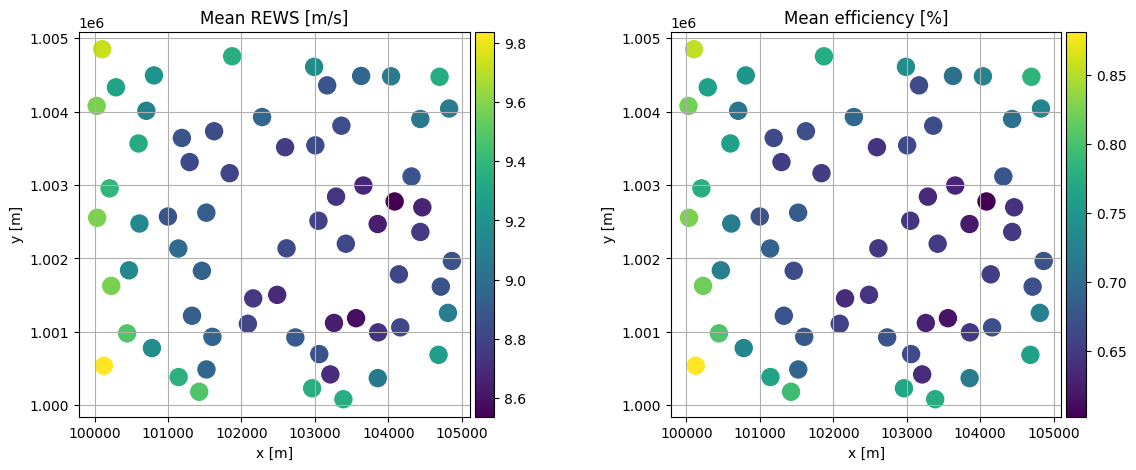

In [8]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
o = foxes.output.FarmLayoutOutput(farm, farm_results)
o.get_figure(fig=fig, ax=axs[0], color_by="mean_REWS", title="Mean REWS [m/s]", s=150, annotate=0)
o.get_figure(fig=fig, ax=axs[1], color_by="mean_EFF", title="Mean efficiency [%]", s=150, annotate=0)
plt.show()

For the fun of it, we can also run this example in parallel, on a local cluster. Depending on the system and the problem size, this is not neccessarily faster than the above implicitely used default dask scheduler, and it comes with overhead. But for complex calculations it is extremely useful and can really save the day. Read the [docs](https://docs.dask.org/en/stable/deploying.html) for more details and parameters. The following invokes the default settings for the local cluster:

In [9]:
with DaskRunner(scheduler="distributed") as runner:
    farm_results = runner.run(algo.calc_farm)

fr = farm_results.to_dataframe()
print("\n", fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.AMB_P, FV.P]])

o = foxes.output.FarmResultsEval(farm_results)
P0 = o.calc_mean_farm_power(ambient=True)
P = o.calc_mean_farm_power()
print(f"\nMean farm power: {P/1000:.1f} MW, Efficiency = {P/P0*100:.2f} %")

Launching local dask cluster..


LocalCluster(44eb5346, 'tcp://127.0.0.1:37291', workers=4, threads=16, memory=7.38 GiB)
Dashboard: http://127.0.0.1:8787/status





Shutting down dask cluster



                                  WD  AMB_REWS       REWS    AMB_P            P
state               turbine                                                   
2017-01-01 00:00:00 0        244.06     15.62  15.610500  5000.00  5000.000000
                    1        244.06     15.62  14.012903  5000.00  5000.000000
                    2        244.06     15.62  15.021033  5000.00  5000.000000
                    3        244.06     15.62  15.560020  5000.00  5000.000000
                    4        244.06     15.62  14.564008  5000.00  5000.000000
...                             ...       ...        ...      ...          ...
2017-06-16 15:30:00 62       299.19     11.70   8.145984  4868.75  1880.222715
                    63       299.19     11.70  11.490711  4868.75  4777.186188
                    64       299.19     11.70  11.700000  4868.75  4868.750000
                    65       299.19     11.70  11.642754  4868.75  4843.705093
                    66       299.19     11.70   8.

Notice the `Dashboard` link, which is only valid during runtime and in this case is a `localhost` address. The dashboard gives plenty of information of the progress during the run and is a very useful tool provided by dask.